In [1]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

import numpy as np

<h3> CZĘŚĆ I: Segmentacja

<h4> Funkcja kosztu Dice - może działać lepiej przy semgentacji niż BCE gdy mamy mały obiekt/duże tło

$D = 1 - \frac{2\sum_i p_iq_i+\epsilon}{\sum_i p_{i}^{2}+\sum_i q_{i}^{2}+\epsilon}$

In [11]:
#definiujemy funkcję kosztu Dice
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs = torch.sigmoid(inputs)  #tego nie musi byc/nie powinno byc jak w naszej sieci do segmentacji mamy juz sigmoid na koncu
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

<h4> Zadanie1 (2 pkt): Rozważ dane SegSperm. Zbuduj model do segmentacji obrazu oparty o architekturę U-Net (swobodnie rozbuduj model z ćwiczeń)


<h4>
    
- Wydziel zbiór treningowy/walidacyjny/testowy (monitoruj proces uczenia).
    
- Potestuj różne hiperparametry/topologie sieci.
 
- W razie konieczności (a ta zapewne będzie występować :) rozważ jako funkcje kosztu DICE -> wyżej) lub kombinacje BCE i DICE (z pewnymi wagami) albo jeszcze inne (poszukaj we własnym zakresie)

- Zaprezentuj przykładowe predykcje modelu. To nie jest łatwe zadanie, jeżeli uda się rozpoznać przynajmniej część obiektu to będzie fajnie! :)

- UWAGA: to sie będzie długo liczyć :( W domu można wziąć mniej zdjęć i spróbować na kilku epokach. Całość można uruchomić w pracowni (proszę o wcześniejszy kontakt)

In [12]:
import os
from PIL import Image
import torch
from torchvision import transforms

img_dir = 'SegSperm/train/images'
mask_dir = 'SegSperm/train/GT1_full'

#transformacje — zamiana na tensory i ewentualna normalizacja
img_transform = transforms.Compose([
    transforms.ToTensor(),  # skala 0-1, kształt (C, H, W)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # opcjonalnie, moze pomoc
])

mask_transform = transforms.Compose([
    transforms.ToTensor()  # zamieni maskę 0/255 → 0.0/1.0
])

#wczytuje wszystkie pliki
image_files = sorted(os.listdir(img_dir))
mask_files = sorted(os.listdir(mask_dir))

images = []
masks = []

for img_name, mask_name in zip(image_files, mask_files):
    # Otwórz obrazy i maski
    img_path = os.path.join(img_dir, img_name)
    mask_path = os.path.join(mask_dir, mask_name)
    
    image = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')  # maska w odcieniach szarości

    #zastosuj transformacje
    image_tensor = img_transform(image)
    mask_tensor = mask_transform(mask)

    #maska jest binarna (0/1)
    mask_tensor = (mask_tensor > 0.5).float()

    images.append(image_tensor)
    masks.append(mask_tensor)

images = torch.stack(images)  # kształt: (N, 3, H, W)
masks = torch.stack(masks)    # kształt: (N, 1, H, W)

print(images.shape, masks.shape)

torch.Size([432, 3, 512, 512]) torch.Size([432, 1, 512, 512])


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

g = torch.Generator()
g.manual_seed(42)
 
train_dataset = TensorDataset(X_train, y_train) #łączy dane i targety w jeden zbior danych
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, generator=g)

val_dataset = TensorDataset(X_val, y_val) 
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

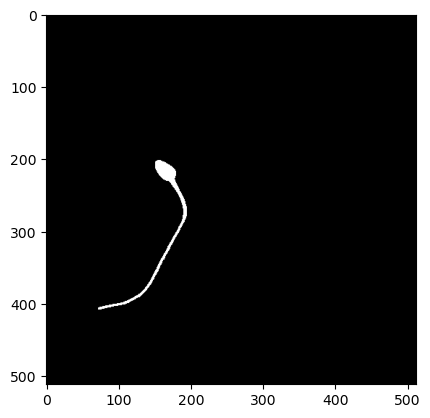

In [14]:
import matplotlib.pyplot as plt
plt.imshow(masks[0][0], cmap='gray') #przykladowy obrazek
plt.show()

In [15]:
num_epochs = 100
print_every_epoch = 10

Model 1: postawowy

Epoch 1/100
  Train -> Total: 0.8532 | BCE: 0.5558 | Dice: 0.9807
  Valid -> Total: 0.8012 | BCE: 0.3820 | Dice: 0.9808

Epoch 11/100
  Train -> Total: 0.5390 | BCE: 0.1015 | Dice: 0.7265
  Valid -> Total: 0.5210 | BCE: 0.0830 | Dice: 0.7087

Epoch 21/100
  Train -> Total: 0.4843 | BCE: 0.0910 | Dice: 0.6529
  Valid -> Total: 0.4492 | BCE: 0.0785 | Dice: 0.6081

Epoch 31/100
  Train -> Total: 0.5043 | BCE: 0.1178 | Dice: 0.6699
  Valid -> Total: 0.4593 | BCE: 0.1037 | Dice: 0.6117

Epoch 41/100
  Train -> Total: 0.4290 | BCE: 0.0945 | Dice: 0.5724
  Valid -> Total: 0.3947 | BCE: 0.0854 | Dice: 0.5272

Epoch 51/100
  Train -> Total: 0.4041 | BCE: 0.0932 | Dice: 0.5373
  Valid -> Total: 0.3844 | BCE: 0.0878 | Dice: 0.5115

Epoch 61/100
  Train -> Total: 0.4635 | BCE: 0.1121 | Dice: 0.6141
  Valid -> Total: 0.4340 | BCE: 0.0967 | Dice: 0.5786

Epoch 71/100
  Train -> Total: 0.4259 | BCE: 0.0960 | Dice: 0.5673
  Valid -> Total: 0.3916 | BCE: 0.0941 | Dice: 0.5191

Epoch 81/100
  Train -> T

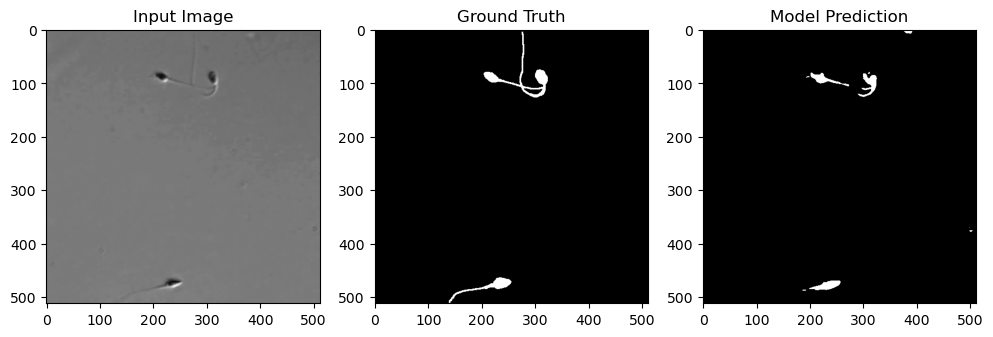

In [ ]:
class Segmentation1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Segmentation1, self).__init__()

        # Enkoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(6, 7, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Dekoder
        self.decoder = nn.Sequential(
            nn.Conv2d(7, 6, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(6, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

input_channels = 3 
output_channels = 1

model = Segmentation1(input_channels, output_channels)
criterion1 = nn.BCELoss()  # Binary Cross Entropy Loss
criterion2 = DiceLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Trening
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_loss_bce = 0
    epoch_loss_dice = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels[:, :, :outputs.size(2), :outputs.size(3)]  

        loss_bce = criterion1(outputs, labels)
        loss_dice = criterion2(outputs, labels)

        loss = 0.3*loss_bce + 0.7*loss_dice 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_loss_bce += loss_bce.item()
        epoch_loss_dice += loss_dice.item()
        
    #Walidaca
    model.eval()
    val_loss = 0
    val_loss_bce = 0
    val_loss_dice = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_labels = val_labels[:, :, :val_outputs.size(2), :val_outputs.size(3)]

            val_loss_bce_i = criterion1(val_outputs, val_labels)
            val_loss_dice_i = criterion2(val_outputs, val_labels)
            val_loss_i = 0.3 * val_loss_bce_i + 0.7 * val_loss_dice_i

            val_loss += val_loss_i.item()
            val_loss_bce += val_loss_bce_i.item()
            val_loss_dice += val_loss_dice_i.item()

    if epoch % print_every_epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train -> Total: {epoch_loss/len(train_loader):.4f} | BCE: {epoch_loss_bce/len(train_loader):.4f} | Dice: {epoch_loss_dice/len(train_loader):.4f}")
        print(f"  Valid -> Total: {val_loss/len(val_loader):.4f} | BCE: {val_loss_bce/len(val_loader):.4f} | Dice: {val_loss_dice/len(val_loader):.4f}\n")

#Predykcja
sample_input = X_test[0:1] # batch z jednym obrazem dla modelu
with torch.no_grad():
    model.eval()
    prediction = torch.round(model(sample_input))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(X_test[0, 0].numpy(), cmap='gray') 
axes[0].set_title('Input Image')

axes[1].imshow(y_test[0, 0].numpy(), cmap='gray') 
axes[1].set_title('Ground Truth')

axes[2].imshow(prediction[0, 0].numpy(), cmap='gray')
axes[2].set_title('Model Prediction')

plt.show()

Model 2: prosty U-net (bez skip connections)

Epoch 1/100
  Train -> Total: 0.8640 | BCE: 0.5938 | Dice: 0.9798
  Valid -> Total: 0.8407  | BCE: 0.5189 | Dice: 0.9785

Epoch 11/100
  Train -> Total: 0.3090 | BCE: 0.0513 | Dice: 0.4195
  Valid -> Total: 0.3449  | BCE: 0.0439 | Dice: 0.4740

Epoch 21/100
  Train -> Total: 0.2887 | BCE: 0.0577 | Dice: 0.3877
  Valid -> Total: 0.2783  | BCE: 0.0513 | Dice: 0.3756

Epoch 31/100
  Train -> Total: 0.2964 | BCE: 0.0736 | Dice: 0.3918
  Valid -> Total: 0.2782  | BCE: 0.0617 | Dice: 0.3710

Epoch 41/100
  Train -> Total: 0.2764 | BCE: 0.0597 | Dice: 0.3693
  Valid -> Total: 0.3125  | BCE: 0.0746 | Dice: 0.4145

Epoch 51/100
  Train -> Total: 0.2669 | BCE: 0.0552 | Dice: 0.3577
  Valid -> Total: 0.2478  | BCE: 0.0483 | Dice: 0.3332

Epoch 61/100
  Train -> Total: 0.2669 | BCE: 0.0601 | Dice: 0.3555
  Valid -> Total: 0.2512  | BCE: 0.0527 | Dice: 0.3363

Epoch 71/100
  Train -> Total: 0.2557 | BCE: 0.0563 | Dice: 0.3412
  Valid -> Total: 0.4073  | BCE: 0.0763 | Dice: 0.5492

Epoch 81/100
  Tr

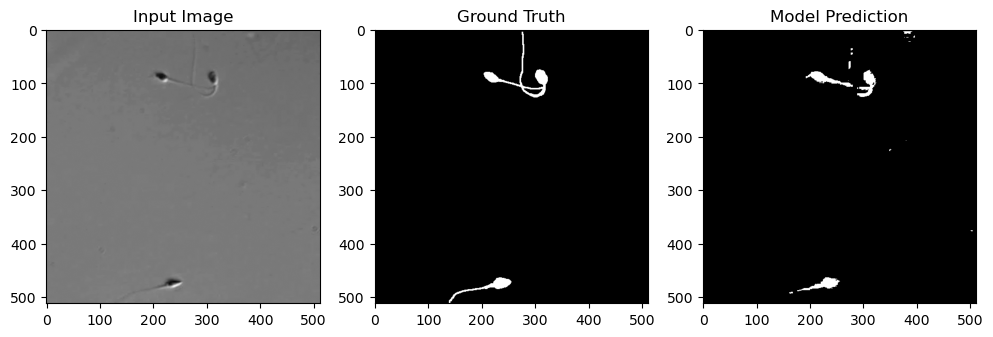

In [ ]:
class Segmentation2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Segmentation2, self).__init__()

        # ENCODER
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # zmniejsza wymiar 2x
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # DECODER
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),  # podwaja wymiar
            nn.ReLU(),
            nn.ConvTranspose2d(16, out_channels, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

input_channels = 3
output_channels = 1


model = Segmentation2(input_channels, output_channels)
criterion1 = nn.BCELoss()  # Binary Cross Entropy Loss
criterion2 = DiceLoss()  #Dice Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Trening
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_loss_bce = 0
    epoch_loss_dice = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels[:, :, :outputs.size(2), :outputs.size(3)]  

        loss_bce = criterion1(outputs, labels)
        loss_dice = criterion2(outputs, labels)

        loss = 0.3*loss_bce + 0.7*loss_dice 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_loss_bce += loss_bce.item()
        epoch_loss_dice += loss_dice.item()

    #Walidaca
    model.eval()
    val_loss = 0
    val_loss_bce = 0
    val_loss_dice = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_labels = val_labels[:, :, :val_outputs.size(2), :val_outputs.size(3)]

            val_loss_bce_i = criterion1(val_outputs, val_labels)
            val_loss_dice_i = criterion2(val_outputs, val_labels)
            val_loss_i = 0.3 * val_loss_bce_i + 0.7 * val_loss_dice_i

            val_loss += val_loss_i.item()
            val_loss_bce += val_loss_bce_i.item()
            val_loss_dice += val_loss_dice_i.item()

    if epoch % print_every_epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train -> Total: {epoch_loss/len(train_loader):.4f} | BCE: {epoch_loss_bce/len(train_loader):.4f} | Dice: {epoch_loss_dice/len(train_loader):.4f}")
        print(f"  Valid -> Total: {val_loss/len(val_loader):.4f}  | BCE: {val_loss_bce/len(val_loader):.4f} | Dice: {val_loss_dice/len(val_loader):.4f}\n")

#Predykcja
sample_input = X_test[0:1] 
with torch.no_grad():
    model.eval()
    prediction = torch.round(model(sample_input))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(X_test[0, 0].numpy(), cmap='gray') 
axes[0].set_title('Input Image')

axes[1].imshow(y_test[0, 0].numpy(), cmap='gray') 
axes[1].set_title('Ground Truth')

axes[2].imshow(prediction[0, 0].numpy(), cmap='gray')
axes[2].set_title('Model Prediction')

plt.show()

Model 3: Pełny U-net (z skip-connections)

Epoch 1/100
  Train -> Total: 0.8799 | BCE: 0.6597 | Dice: 0.9742
  Valid -> Total: 0.8795 | BCE: 0.6495 | Dice: 0.9781

Epoch 11/100
  Train -> Total: 0.6922 | BCE: 0.1810 | Dice: 0.9114
  Valid -> Total: 0.6884 | BCE: 0.1793 | Dice: 0.9066

Epoch 21/100
  Train -> Total: 0.3939 | BCE: 0.0390 | Dice: 0.5460
  Valid -> Total: 0.7518 | BCE: 0.4192 | Dice: 0.8944

Epoch 31/100
  Train -> Total: 0.2451 | BCE: 0.0375 | Dice: 0.3341
  Valid -> Total: 0.2764 | BCE: 0.0348 | Dice: 0.3800

Epoch 41/100
  Train -> Total: 0.2092 | BCE: 0.0386 | Dice: 0.2823
  Valid -> Total: 0.2017 | BCE: 0.0413 | Dice: 0.2705

Epoch 51/100
  Train -> Total: 0.1976 | BCE: 0.0395 | Dice: 0.2653
  Valid -> Total: 0.1897 | BCE: 0.0369 | Dice: 0.2551

Epoch 61/100
  Train -> Total: 0.1901 | BCE: 0.0409 | Dice: 0.2540
  Valid -> Total: 0.2611 | BCE: 0.0507 | Dice: 0.3512

Epoch 71/100
  Train -> Total: 0.1859 | BCE: 0.0402 | Dice: 0.2483
  Valid -> Total: 0.1825 | BCE: 0.0372 | Dice: 0.2447

Epoch 81/100
  Train -> T

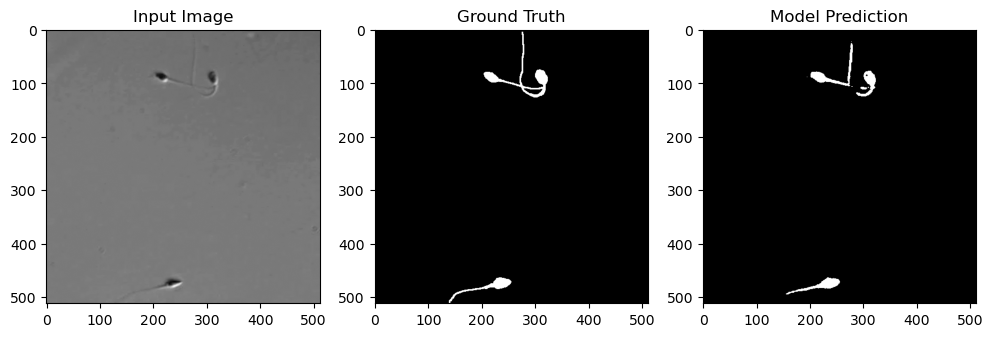

In [ ]:
import torch
import torch.nn as nn

class Segmentation3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Segmentation3, self).__init__()

        # ENCODER
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # DECODER
        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(16 + 32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(8 + 16, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )

        self.final = nn.Conv2d(8, out_channels, 1)

    def forward(self, x):
        # ENCODER
        x1 = self.enc1(x)  # [B,16,H,W]
        p1 = self.pool1(x1)  # [B,16,H/2,W/2]

        x2 = self.enc2(p1)  # [B,32,H/2,W/2]
        p2 = self.pool2(x2) # [B,32,H/4,W/4]

        d1 = self.up1(p2)              #[B,32,H/2,W/2] -> [B,16,H/2,W/2]
        d1 = torch.cat([d1, x2], dim=1)  # concatenate with 2nd encoder [B,32,H/2,W/2]
        d1 = self.dec1(d1)

        d2 = self.up2(d1)              
        d2 = torch.cat([d2, x1], dim=1)  # concatenate with 1st encoder[B,16,H,W]
        d2 = self.dec2(d2)


        out = torch.sigmoid(self.final(d2))
        return out


input_channels = 3 
output_channels = 1


model = Segmentation3(input_channels, output_channels)
criterion1 = nn.BCELoss() 
criterion2 = DiceLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Trening
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_loss_bce = 0
    epoch_loss_dice = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels[:, :, :outputs.size(2), :outputs.size(3)]  

        loss_bce = criterion1(outputs, labels)
        loss_dice = criterion2(outputs, labels)

        loss = 0.3*loss_bce + 0.7*loss_dice 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_loss_bce += loss_bce.item()
        epoch_loss_dice += loss_dice.item()

    #Walidaca
    model.eval()
    val_loss = 0
    val_loss_bce = 0
    val_loss_dice = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_labels = val_labels[:, :, :val_outputs.size(2), :val_outputs.size(3)]

            val_loss_bce_i = criterion1(val_outputs, val_labels)
            val_loss_dice_i = criterion2(val_outputs, val_labels)
            val_loss_i = 0.3 * val_loss_bce_i + 0.7 * val_loss_dice_i

            val_loss += val_loss_i.item()
            val_loss_bce += val_loss_bce_i.item()
            val_loss_dice += val_loss_dice_i.item()

    if epoch % print_every_epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train -> Total: {epoch_loss/len(train_loader):.4f} | BCE: {epoch_loss_bce/len(train_loader):.4f} | Dice: {epoch_loss_dice/len(train_loader):.4f}")
        print(f"  Valid -> Total: {val_loss/len(val_loader):.4f} | BCE: {val_loss_bce/len(val_loader):.4f} | Dice: {val_loss_dice/len(val_loader):.4f}\n")

#Predykcja
sample_input = X_test[0:1] 
with torch.no_grad():
    model.eval()
    prediction = torch.round(model(sample_input))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(X_test[0, 0].numpy(), cmap='gray') 
axes[0].set_title('Input Image')

axes[1].imshow(y_test[0, 0].numpy(), cmap='gray') 
axes[1].set_title('Ground Truth')

axes[2].imshow(prediction[0, 0].numpy(), cmap='gray')
axes[2].set_title('Model Prediction')

plt.show()

Model 4: Pełny U-net + bottle neck

Epoch 1/100
  Train -> Total: 0.8092 | BCE: 0.4522 | Dice: 0.9621
  Valid -> Total: 0.7958| BCE: 0.3782 | Dice: 0.9747

Epoch 11/100
  Train -> Total: 0.3500 | BCE: 0.0343 | Dice: 0.4852
  Valid -> Total: 0.6592| BCE: 0.2177 | Dice: 0.8484

Epoch 21/100
  Train -> Total: 0.1878 | BCE: 0.0334 | Dice: 0.2539
  Valid -> Total: 0.1833| BCE: 0.0389 | Dice: 0.2453

Epoch 31/100
  Train -> Total: 0.1647 | BCE: 0.0313 | Dice: 0.2219
  Valid -> Total: 0.1766| BCE: 0.0360 | Dice: 0.2369

Epoch 41/100
  Train -> Total: 0.1968 | BCE: 0.0354 | Dice: 0.2659
  Valid -> Total: 0.2298| BCE: 0.0531 | Dice: 0.3055

Epoch 51/100
  Train -> Total: 0.1542 | BCE: 0.0294 | Dice: 0.2077
  Valid -> Total: 0.1589| BCE: 0.0301 | Dice: 0.2141

Epoch 61/100
  Train -> Total: 0.1493 | BCE: 0.0280 | Dice: 0.2013
  Valid -> Total: 0.1537| BCE: 0.0344 | Dice: 0.2048

Epoch 71/100
  Train -> Total: 0.1479 | BCE: 0.0277 | Dice: 0.1994
  Valid -> Total: 0.1600| BCE: 0.0314 | Dice: 0.2152

Epoch 81/100
  Train -> Total: 0.

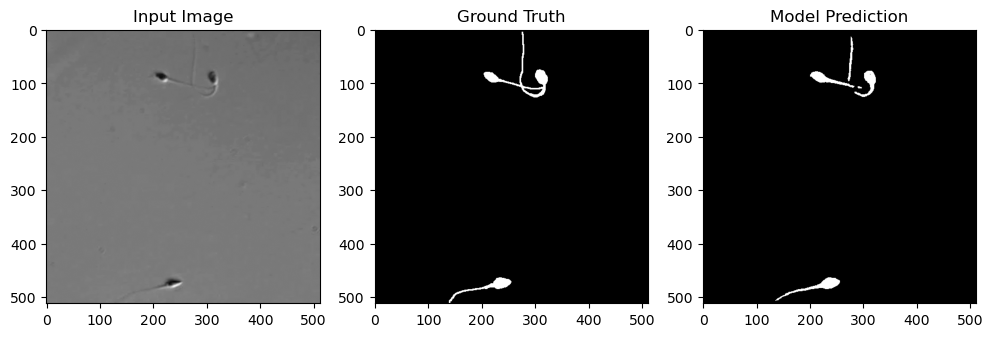

In [ ]:
class Segmentation4(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Segmentation4, self).__init__()

        # ENCODER
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # DECODER
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),   # 32 + 32 (skip)
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),   # 16 + 16 (skip)
            nn.BatchNorm2d(16),
            nn.ReLU()
        )

        self.final = nn.Conv2d(16, out_channels, 1)
        
    def forward(self, x):
        # ENCODER
        x1 = self.enc1(x)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        p2 = self.pool2(x2)

        x3 = self.bottleneck(p2)

        # DECODER
        d1 = self.up1(x3)
        d1 = torch.cat([d1, x2], dim=1)  # skip connection
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, x1], dim=1)
        d2 = self.dec2(d2)

        out = torch.sigmoid(self.final(d2))
        return out


input_channels = 3 
output_channels = 1

model = Segmentation4(input_channels, output_channels)
criterion1 = nn.BCELoss()  
criterion2 = DiceLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)


#Trening
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_loss_bce = 0
    epoch_loss_dice = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels[:, :, :outputs.size(2), :outputs.size(3)]  

        loss_bce = criterion1(outputs, labels)
        loss_dice = criterion2(outputs, labels)

        loss = 0.3*loss_bce + 0.7*loss_dice 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_loss_bce += loss_bce.item()
        epoch_loss_dice += loss_dice.item()
    #Walidaca
    model.eval()
    val_loss = 0
    val_loss_bce = 0
    val_loss_dice = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_outputs = model(val_inputs)
            val_labels = val_labels[:, :, :val_outputs.size(2), :val_outputs.size(3)]

            val_loss_bce_i = criterion1(val_outputs, val_labels)
            val_loss_dice_i = criterion2(val_outputs, val_labels)
            val_loss_i = 0.3 * val_loss_bce_i + 0.7 * val_loss_dice_i

            val_loss += val_loss_i.item()
            val_loss_bce += val_loss_bce_i.item()
            val_loss_dice += val_loss_dice_i.item()

    if epoch % print_every_epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train -> Total: {epoch_loss/len(train_loader):.4f} | BCE: {epoch_loss_bce/len(train_loader):.4f} | Dice: {epoch_loss_dice/len(train_loader):.4f}")
        print(f"  Valid -> Total: {val_loss/len(val_loader):.4f}| BCE: {val_loss_bce/len(val_loader):.4f} | Dice: {val_loss_dice/len(val_loader):.4f}\n")

    #Save model
    torch.save(model.state_dict(), 'model.ckpt')

#Predykcja
sample_input = X_test[0:1]
with torch.no_grad():
    model.eval()
    prediction = torch.round(model(sample_input))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(X_test[0, 0].numpy(), cmap='gray') 
axes[0].set_title('Input Image')

axes[1].imshow(y_test[0, 0].numpy(), cmap='gray') 
axes[1].set_title('Ground Truth')

axes[2].imshow(prediction[0, 0].numpy(), cmap='gray')
axes[2].set_title('Model Prediction')

plt.show()

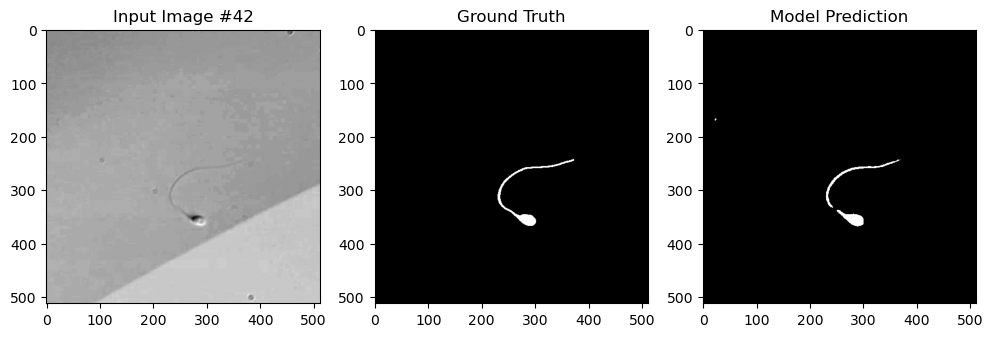

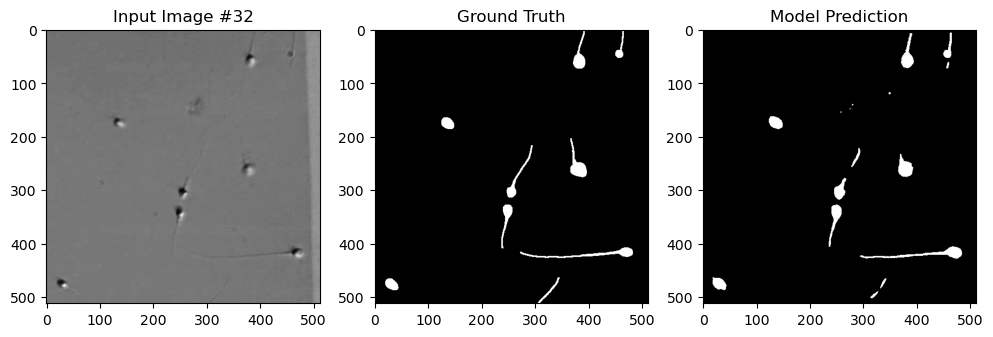

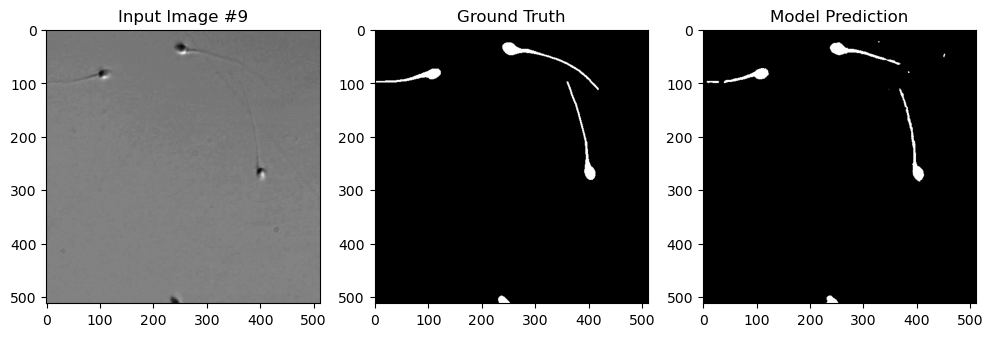

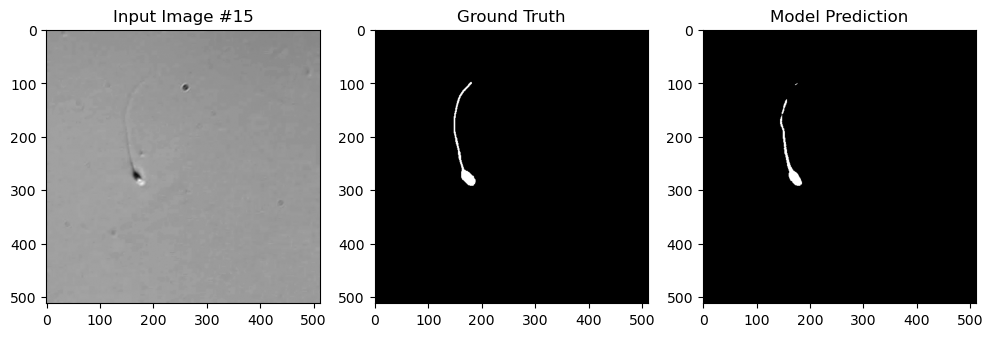

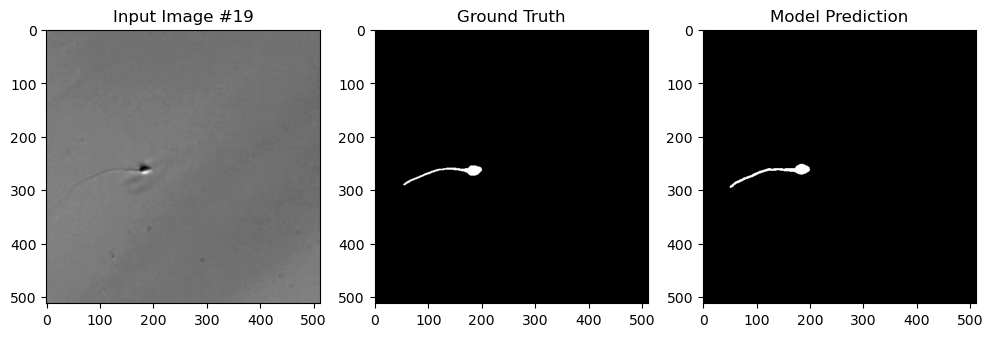

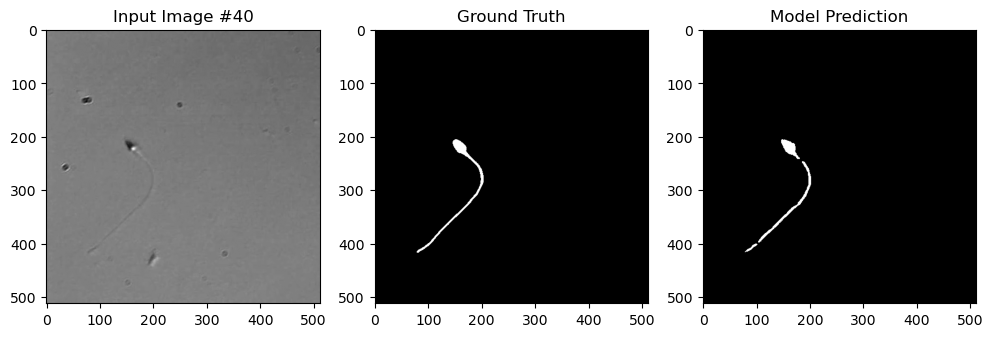

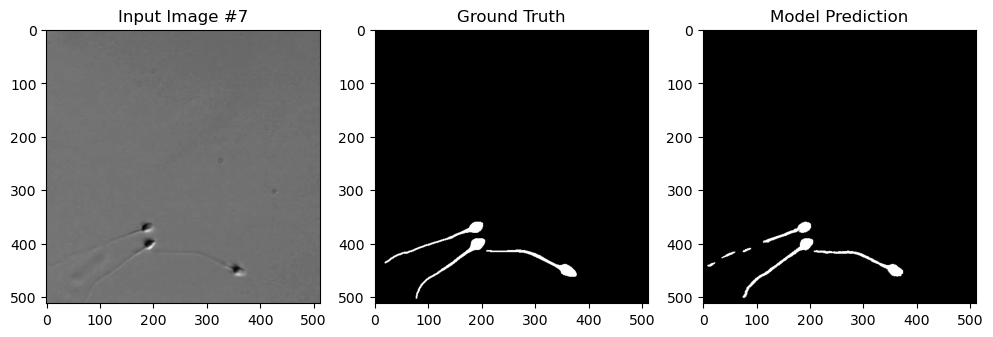

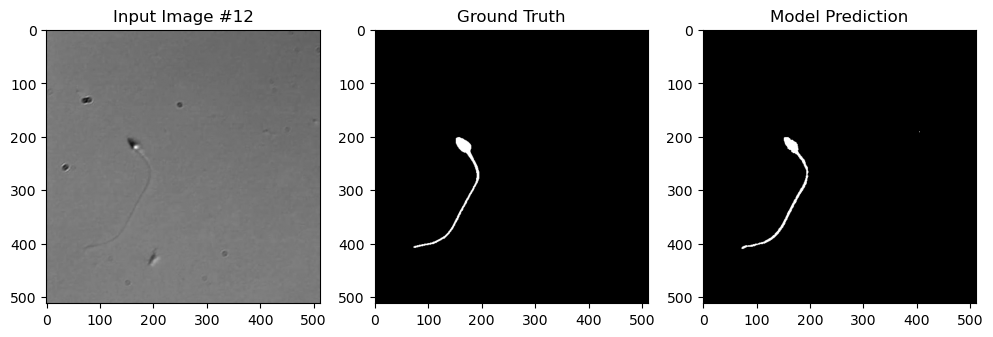

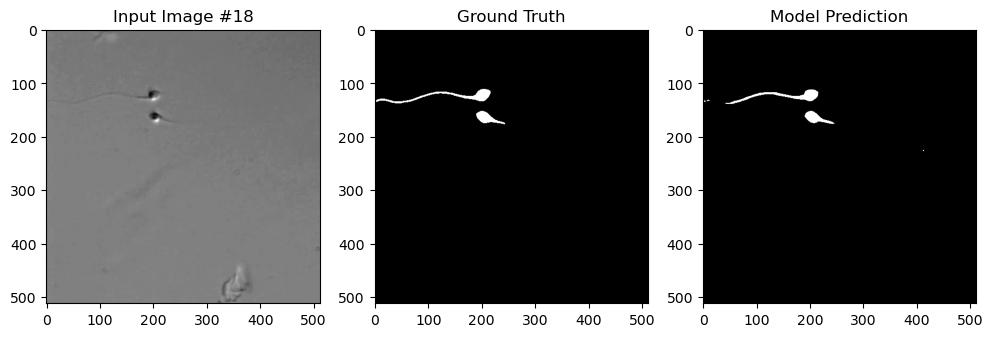

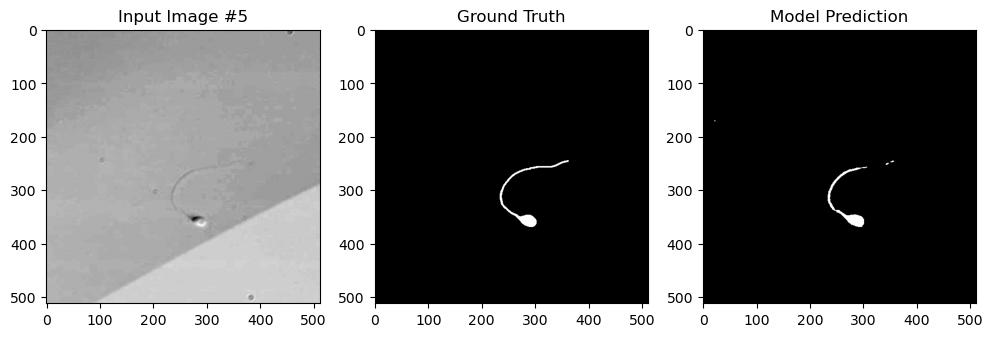

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()

n_examples = 10

#losowy wybór indeksów z X_test
indices = np.random.choice(len(X_test), n_examples, replace=False)

with torch.no_grad():
    for idx in indices:
        sample_input = X_test[idx:idx+1]  # batch z jednym obrazem
        prediction = torch.round(model(sample_input))

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(X_test[idx, 0].numpy(), cmap='gray')
        axes[0].set_title(f'Input Image #{idx}')

        axes[1].imshow(y_test[idx, 0].numpy(), cmap='gray')
        axes[1].set_title('Ground Truth')

        axes[2].imshow(prediction[0, 0].numpy(), cmap='gray')
        axes[2].set_title('Model Prediction')

        plt.show()


<h3> CZĘŚĆ II: Autoenkodery

## Wasserstein Autoencoder
Kolejnym zadaniem będzie zaimplementowanie Autoenkodera Wassersteina (Wasserstein Autoencoder) z kosztem Maximum Mean Discrepancy. Model ten jest identyczny pod względem architektury do zwyczajnego autoenkodera, ale dodatkowo wymusza żeby przykłady w przestrzeni ukrytej układały się w rozkład normalny. Dzięki temu po nauczeniu będziemy mogli generować nowe przykłady, samplując szum z rozkładu normalnego i przepuszczając go przez dekoder naszego autoenkodera.

W rezultacie WAE składa się ponownie z dwóch komponentów: Enkodera $\mathcal{E}$ oraz dekodera $\mathcal{D}$. Funkcja kosztu wygląda teraz następująco:

$$
\mathcal{L}_{WAE-MMD} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|^2+
C d^2_k((\mathcal{E} x_i),(z_j)),
$$

gdzie $z_j$ to sample wygenerowane z rozkładu normalnego $\mathcal{N}(0, I)$ a $C \in \mathcal{R}$ to hiperparametr ważący komponenty funkcji kosztu.

Pierwszy człon kosztu to koszt rekonstrukcji taki sam jak w przypadku zwyczajnego autoenkodera. Drugi człon funkcji kosztu to koszt MMD, zadany wzorem: 
$$
d^2_k((y_i),(z_j))=\frac{1}{n^2}\sum_{i,i'}k(y_i,y_{i'})+\frac{1}{n^2}\sum_{j,j'}k(z_j,z_{j'})-\frac{2}{n^2}\sum_{i,j}k(y_i,z_j),
$$
gdzie $k$ to wybrany przez nas kernel.

Koszt ten opisuje odległość pomiędzy reprezentacją ukrytą $y_i = \mathcal{E}x_i$ otrzymaną po przepuszczeniu przykładów treningowych przez enkoder a samplami $z_i$ wygenerowanymi z rozkładu normalnego $\mathcal{N}(0, I)$. Tym samym minimalizując ten koszt sprawimy że rozkład zadany przez enkoder będzie bardziej podobny do rozkładu normalnego, do którego chcemy się dopasować.

Na potrzeby zadania proszę skorzystać z kernela IMQ (inverse multi-quadratic) zadanego wzorem:
$$
k(y, z)=\frac{\sigma}{\sigma+\|y - z \|^2},
$$
gdzie $\sigma$ to hiperparametr, który trzeba znaleźć. 



<h4> Zadanie2 (2 pkt.)
    
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera Wassersteina (enkoder + dekoder). Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować elementy pętli uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae). 



In [31]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Lambda, Compose


#dane FashionMNIST 
transforms = Compose([ToTensor()]) #Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=False)

batch_size = 256

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 

In [32]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        
        D = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1), #nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, D, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(D, 256, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        enc = self.encode(x)
        dec = self.decode(enc)
        return enc, dec
        
    def k(self, norm, sigma):
        return sigma / (sigma + norm)
    
    def mmd_loss(self, y, sigma):
        z = torch.randn_like(y)
        yy = torch.cdist(y.view(len(y), -1), y.view(len(y), -1))**2 #suma po każej parze, spłaszczamy wektory w inpucie 
        zz = torch.cdist(z.view(len(z), -1), z.view(len(z), -1))**2
        yz = torch.cdist(y.view(len(y), -1), z.view(len(z), -1))**2
     
        return self.k(yy, sigma).mean() + self.k(zz, sigma).mean() - 2 * self.k(yz, sigma).mean() #mean bo to macierz nxn

    def total_loss(self, x, decoded, sigma, C):
        mse = F.mse_loss(decoded, x)
        enc = self.encode(x)
        mmd = self.mmd_loss(enc, sigma)
        return mse + C * mmd

Epoch: 0 | train loss: 0.13088


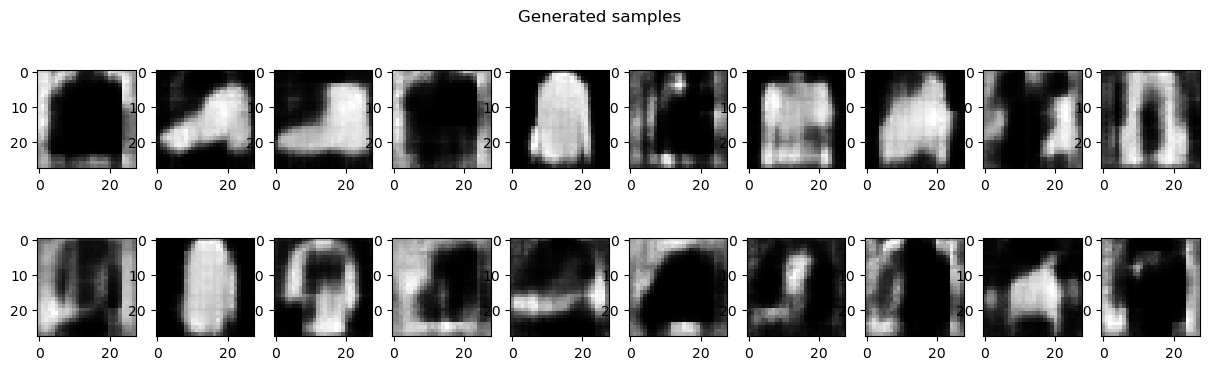

Epoch: 10 | train loss: 0.01474


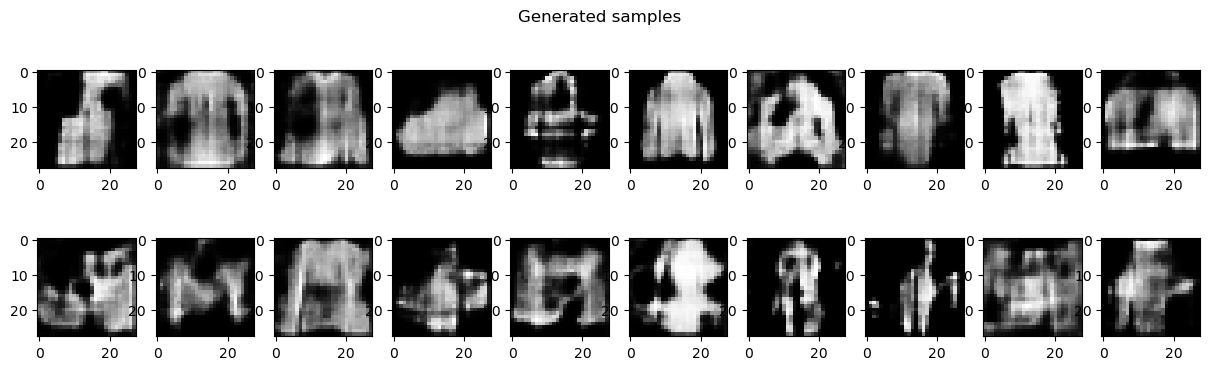

Epoch: 20 | train loss: 0.01301


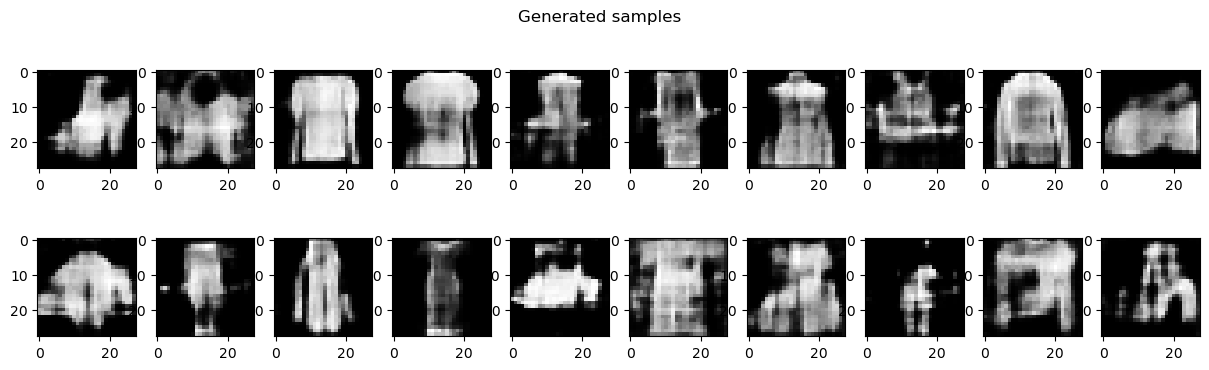

Epoch: 30 | train loss: 0.01234


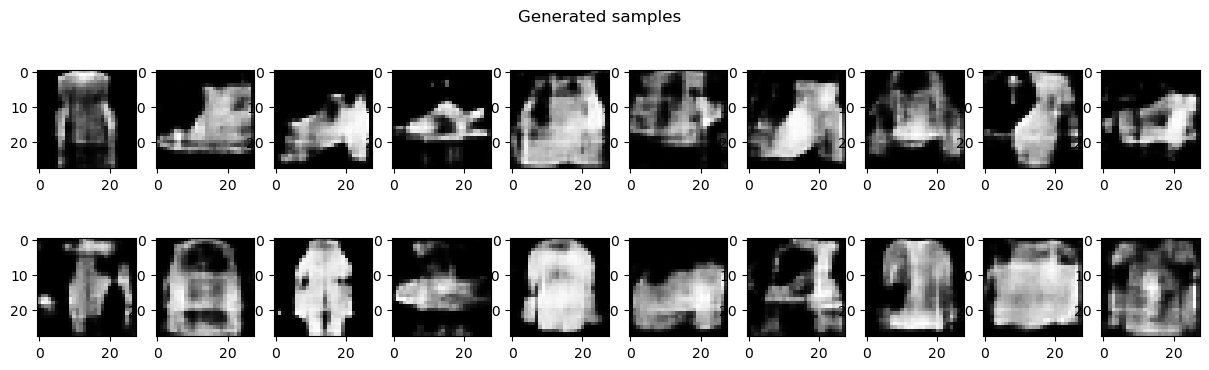

Epoch: 40 | train loss: 0.01186


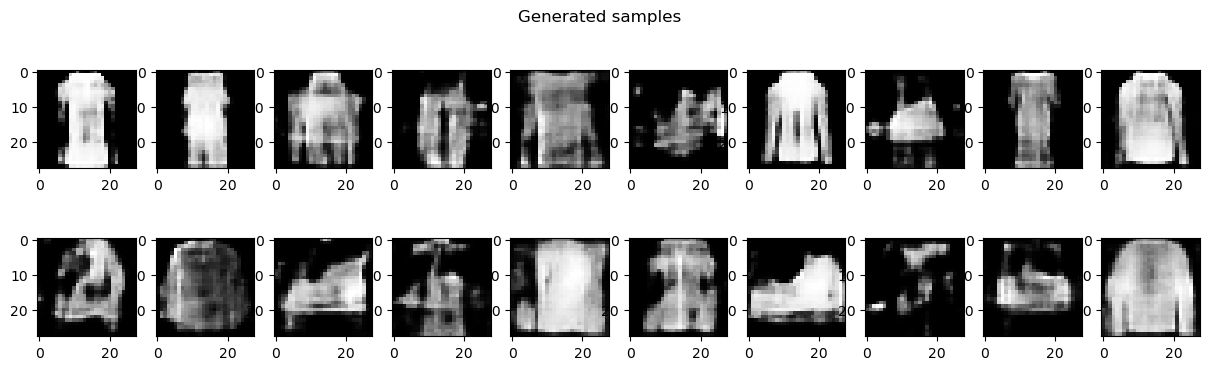

Epoch: 50 | train loss: 0.01171


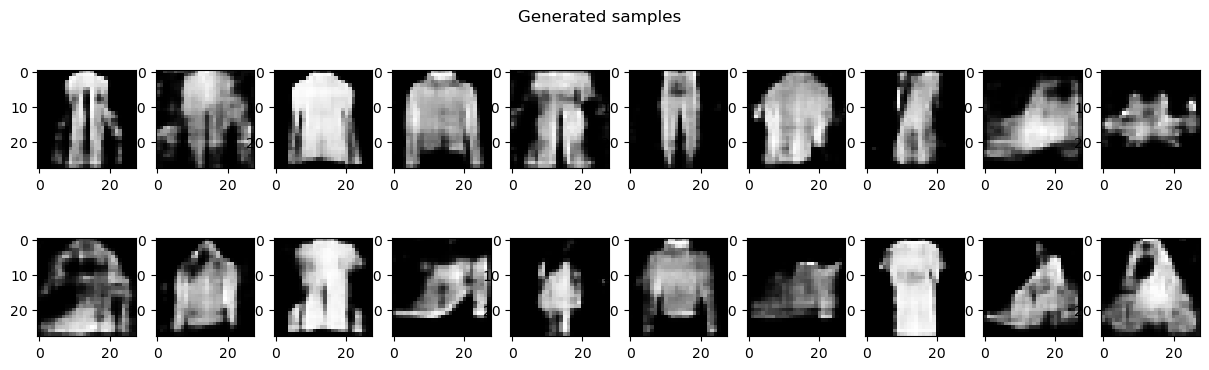

Epoch: 60 | train loss: 0.01131


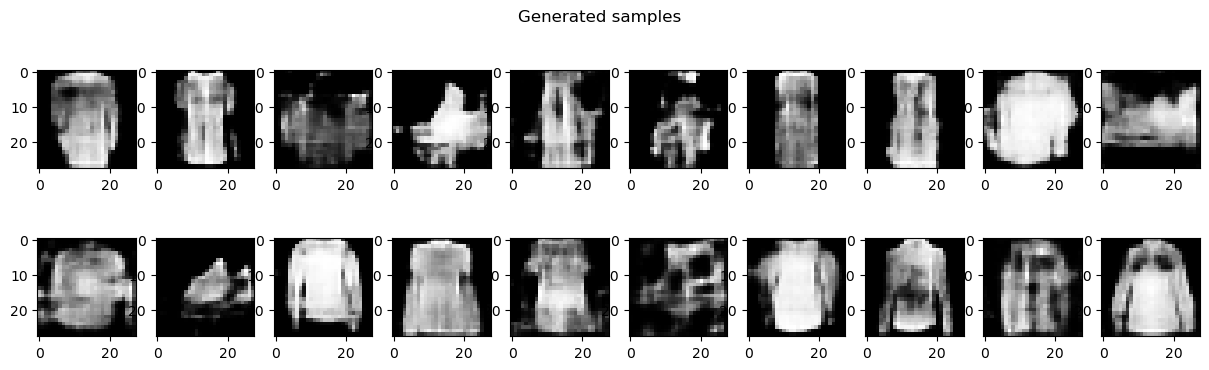

Epoch: 70 | train loss: 0.01120


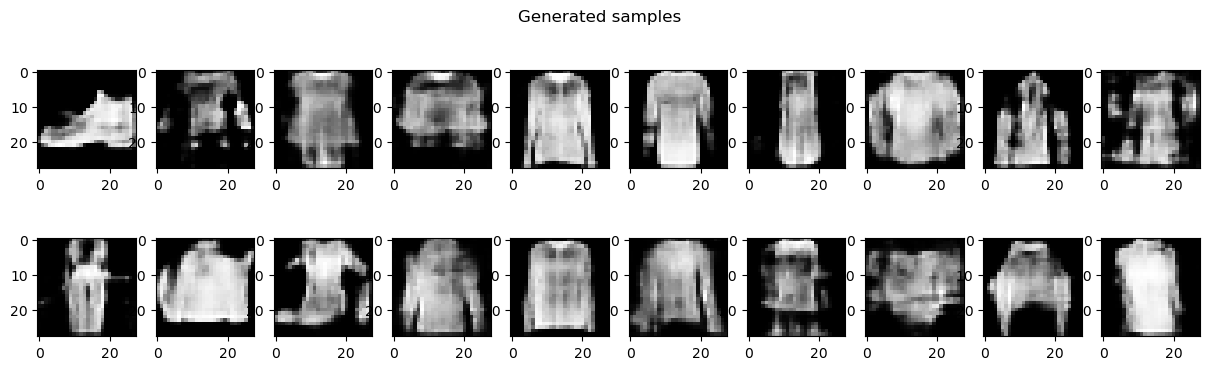

Epoch: 80 | train loss: 0.01098


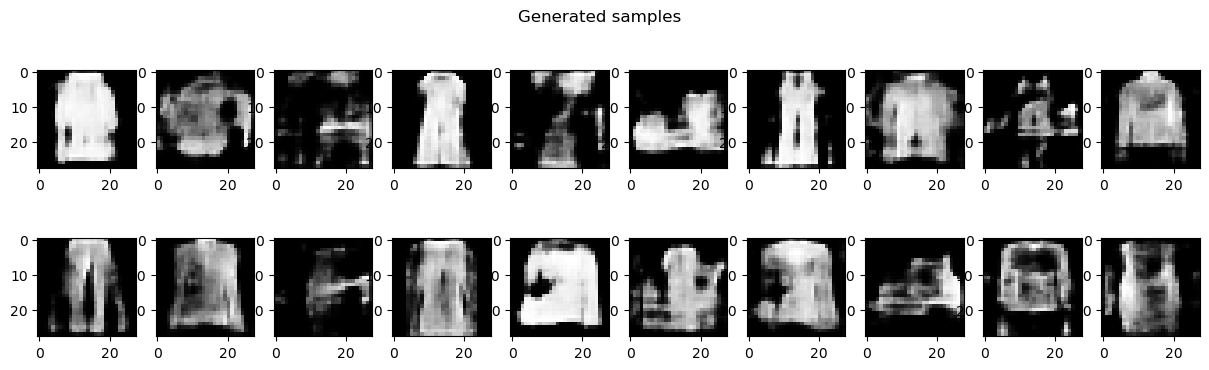

Epoch: 90 | train loss: 0.01093


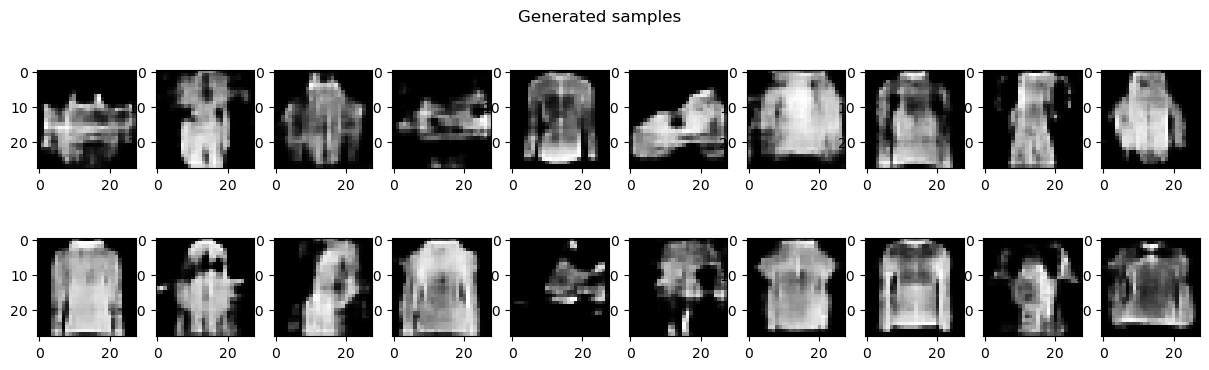

In [33]:
def plot_samples(model):
    # generowanie wartosci z rozkladu normalnego i przerzucanie przez dekoder
    sampled_z = torch.randn(20, model.latent_dim,1,1) # warstwa oczekuje 4D (batch_size, in_channels, height, width)
    generated = model.decode(sampled_z)

    #graficzna prezentacja wynikow
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

# Hiperparametry 
epochs = 100
LR = 1e-3
latent_dim = 32
sigma = 2 * latent_dim
C = 1

wae = WAEMMD(latent_dim)
optimizer = torch.optim.Adam(wae.parameters(), lr=LR)


rec_loss_fn = torch.nn.MSELoss() #klasysczna funkcja MSE

for epoch in range(epochs):
    epoch_losses = []
    for step, (x, y) in enumerate(train_loader):
        encoded, decoded = wae(x)

        rec_loss_val = torch.nn.MSELoss(wae) #nalezy wyznaczyc i zapisac do zmiennej wartosc funkcji kosztu MSE
        latent_loss_val = wae.mmd_loss(x, sigma) #nalezy wyznaczyc i zapisac do zmiennej wartosc funkcji kosztu MSD
        loss_val = wae.total_loss(x, decoded, sigma, C) #finalną wartosc funkcji kosztu nalezy wyznaczyc wg odpowiedniego wzoru


        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        epoch_losses += [loss_val.item()]

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | train loss: {np.mean(epoch_losses):.5f}')
        plot_samples(wae)
